### Phobri Magnet Simulations

code based off of https://colab.research.google.com/drive/1HVRIb3Qq9XZ483U3ilCqhAcSNHraJKJO?usp=sharing#scrollTo=laQSVtL3qm4H

In [335]:
try:
  import google.colab
  IN_COLAB=True
except:
  IN_COLAB=False
  pass

if IN_COLAB:
  !pip install magpylib

In [336]:
import magpylib as magpy
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from types import *

from magpylib.magnet import Cylinder, CylinderSegment

In [337]:
# GLOBAL CONSTANTS
DIST_PCB_TO_STICK_AXLE = 7 # mm
STICKBOX_LENGTH = 15 # mm
DIST_PCB_SENSOR = 0.65 # mm
STICK_FULL_TILT = 30 # deg
ROT_STEPS = 40
ADC_CONV = 684.2 # (ADC LSB)/mT

In [338]:
def sim_magnetic_flux(magnet, sensor_pos, show_animation=False):
  magnet_x = magnet(True)
  magnet_y = magnet(False)

  magnet_x.position = (0,0,DIST_PCB_TO_STICK_AXLE)
  magnet_y.position = (STICKBOX_LENGTH/2,STICKBOX_LENGTH/2,DIST_PCB_TO_STICK_AXLE)

  sensor = magpy.Sensor(position=(sensor_pos[0], sensor_pos[1], DIST_PCB_SENSOR))

  # snippet for potentially testing stick press
  #disp_x = [np.zeros(animation_steps*animation_steps), np.zeros(animation_steps*animation_steps), np.sin(np.linspace(0, -100, animation_steps*animation_steps))]
  # turn disp_x into an array of 3-tuples
  #disp_x = np.array(disp_x).T

  
  stick_angles = np.linspace(+STICK_FULL_TILT, -STICK_FULL_TILT, ROT_STEPS)
  magnet_x.rotate_from_angax(stick_angles, "y",
                           anchor=(0,0,DIST_PCB_TO_STICK_AXLE), start=0)
  magnet_y.rotate_from_angax(stick_angles, "x",
                           anchor=(STICKBOX_LENGTH/2, STICKBOX_LENGTH/2, DIST_PCB_TO_STICK_AXLE), start=0)
  
  if show_animation:
    magpy.show(sensor, magnet_x, magnet_y, backend="plotly", animation=True)

  Bmx = sensor.getB(magnet_x) * ADC_CONV 
  Bmy = sensor.getB(magnet_y) * ADC_CONV
  
  return (Bmx, Bmy)

In [339]:
def scatter_plot_from_b(Bs):  
    Bmx = np.repeat(Bs[0], ROT_STEPS, axis=0)
    Bmy = np.tile(Bs[1],(ROT_STEPS,1))
    Bsum = Bmx + Bmy
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel("Bx")
    ax.set_ylabel("By")
    ax.set_zlabel("Bz")
    ax.scatter(Bsum[:,0], Bsum[:,1], Bsum[:,2], color="red")
    fig.show()

def derivative_test(Bs):
    # show the derivative of each axis of B
    fig, axs = plt.subplots(2,3, width_ratios=[2.0,2.0,2.0], sharey=True, sharex=True)

    xdata = np.linspace(+STICK_FULL_TILT, -STICK_FULL_TILT, ROT_STEPS-1)
    Bmx_diff = np.diff(Bs[0], axis=0)
    Bmy_diff = np.diff(Bs[1], axis=0)
    for magnet in range(2):
        for axis in range(3):
            B_diff = [Bmx_diff,Bmy_diff][magnet]
            axs[magnet][axis].set_title("dB{}/dθ M={}".format(["x","y","z"][axis], ["x","y"][magnet]))
            axs[magnet][axis].plot(xdata, B_diff[:,axis])
    fig.tight_layout()
    fig.show()

In [340]:
DH1H1_HEIGHT_DIAM = 1/10 * 25.4
def MAG_CYLINDER(axis_x):
    mag = Cylinder(magnetization=(0, 0, 1300), dimension=(DH1H1_HEIGHT_DIAM, DH1H1_HEIGHT_DIAM))
    if axis_x:
        mag.rotate_from_euler(90*3, "y")
    else:
        mag.rotate_from_euler(90, "x")
    print(type(mag))
    return mag
        
def MAG_RING(axis_x):
    mag = CylinderSegment(magnetization=(1300,1300,0), dimension=(1,2,1,0,360))
    if axis_x:
        mag.rotate_from_euler([90,90], "yz")
    else:
        mag.rotate_from_euler([90,90], "xz")
        mag.rotate_from_euler(90, "x")
    return mag

In [341]:
# more constants, various things to test/tweak
SENSOR_MISALIGNMENT_X = 0 
SENSOR_MISALIGNMENT_Y = 0.5

<class 'magpylib._src.obj_classes.class_magnet_Cylinder.Cylinder'>
<class 'magpylib._src.obj_classes.class_magnet_Cylinder.Cylinder'>


C:\Users\panther\AppData\Local\Temp\ipykernel_18364\3531456587.py:11: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\panther\AppData\Local\Temp\ipykernel_18364\3531456587.py:26: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



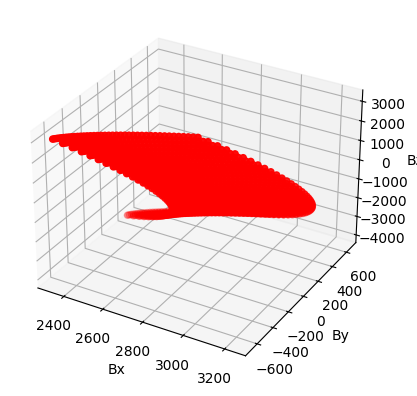

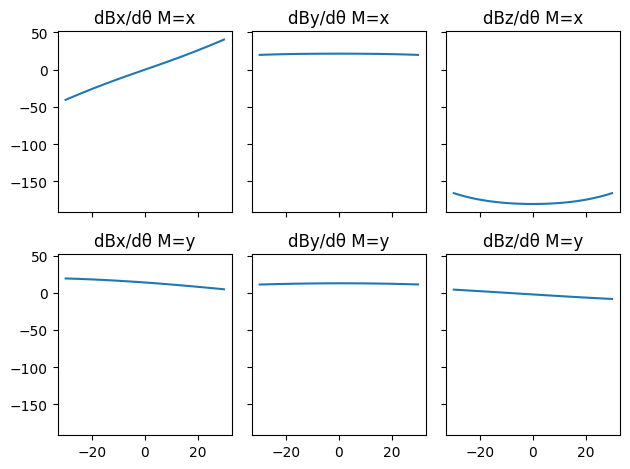

In [342]:
# Cylinder magnet test, sensor per magnet
Bs= sim_magnetic_flux(MAG_CYLINDER, (SENSOR_MISALIGNMENT_X,SENSOR_MISALIGNMENT_Y), True)
%matplotlib inline
scatter_plot_from_b(Bs)
derivative_test(Bs)

<class 'magpylib._src.obj_classes.class_magnet_Cylinder.Cylinder'>
<class 'magpylib._src.obj_classes.class_magnet_Cylinder.Cylinder'>


C:\Users\panther\AppData\Local\Temp\ipykernel_18364\3531456587.py:11: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\panther\AppData\Local\Temp\ipykernel_18364\3531456587.py:26: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



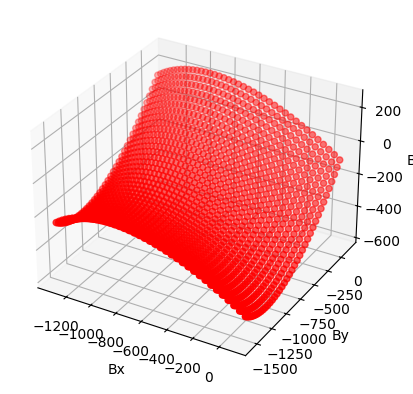

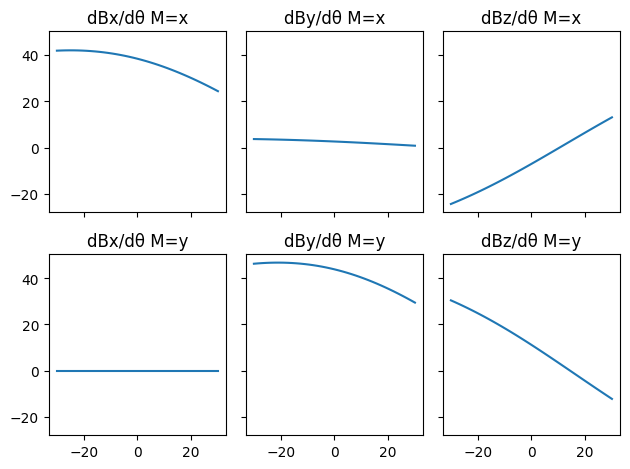

In [343]:
Bs = sim_magnetic_flux(MAG_CYLINDER, (STICKBOX_LENGTH/2 + SENSOR_MISALIGNMENT_X, SENSOR_MISALIGNMENT_Y))

scatter_plot_from_b(Bs)
derivative_test(Bs)

C:\Users\panther\AppData\Local\Temp\ipykernel_18364\3531456587.py:11: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\panther\AppData\Local\Temp\ipykernel_18364\3531456587.py:26: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



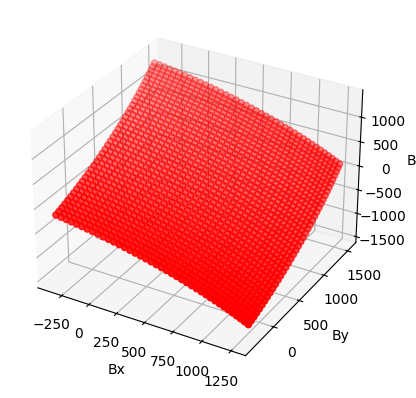

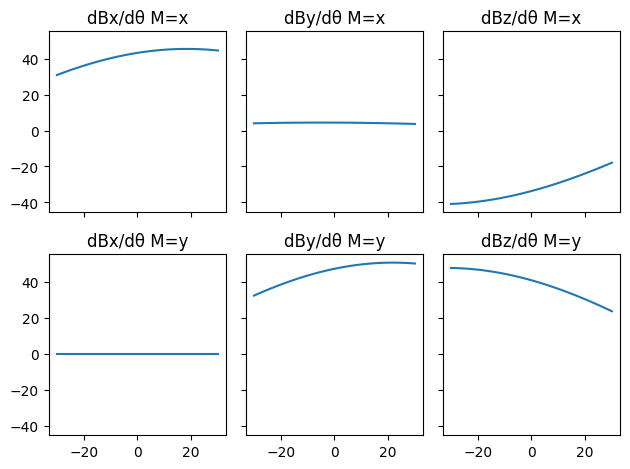

In [344]:
Bs = sim_magnetic_flux(MAG_RING, (STICKBOX_LENGTH/2 + SENSOR_MISALIGNMENT_X, SENSOR_MISALIGNMENT_Y), True)

scatter_plot_from_b(Bs)
derivative_test(Bs)